In [1]:
import os
import copy
import numpy as np
from scipy import signal, stats, constants
from scipy.optimize import minimize, curve_fit
import h5py as hp
import re

import matplotlib.pyplot as plt
import matplotlib as mplt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyproj as proj
from scipy.spatial.transform import Rotation as R

plt.style.use('/home/dilraj/.config/matplotlib/matplotlib.rc')
prop_cycle = plt.rcParams['axes.prop_cycle']   
colors = prop_cycle.by_key()['color']   

h_mult = 1.0 #0.75
scale  = 1.0
width  = 5.906 * scale
height = width / 1.618 * h_mult

In [2]:
Test_LOC = {
    1:[48 + 38.644/60, 123 + 29.717/60],
    2:[48 + 38.611/60, 123 + 29.811/60],
    3:[48 + 38.614/60, 123 + 29.592/60],
    4:[48 + 38.719/60, 123 + 29.718/60],
    5:[48 + 39.138/60, 123 + 29.695/60],
    6:[48 + 38.977/60, 123 + 29.752/60],
    7:[48 + 39.199/60, 123 + 29.689/60],
    8:[48 + 39.468/60, 123 + 29.723/60]
}

Beacon_LOC = {
    3008:[48 + 38.704/60, 123 + 29.821/60],
    2404:[48 + 38.571/60, 123 + 29.710/60],
    2407:[48 + 38.697/60, 123 + 29.598/60]
}

LOC_1 = {
    'start':[48 + 38.649/60, 123 + 29.715/60],
    'mid':[48 + 38.650/60, 123 + 29.717/60],
    'end':[48 + 38.649/60, 123 + 29.717/60]
}

LOC_8 = {
    'start':[48 + 39.460/60, 123 + 29.712/60],
    'mid':[48 + 39.463/60, 123 + 29.718/60],
    'end':[48 + 39.468/60, 123 + 29.723/60]
}

LOC_7 = {
    'start':[48 + 39.199/60, 123 + 29.672/60],
    'mid':[48 + 39.203/60, 123 + 29.684/60],
    'end':[48 + 39.199/60, 123 + 29.689/60]
}


In [3]:
def transform_cart(lats, longs, height):
    transformer = proj.Transformer.from_crs("+proj=latlong +datum=WGS84", "+proj=geocent +datum=WGS84")
    xyz_point = transformer.transform(longs, lats, height)
    return xyz_point

def get_rotation_info(ref_points):
    # Expects to get ref_points as 3 points which it will rotate onto xy
    #ref_points = ref_points.T
    u = ref_points[:,0] - ref_points[:,1]
    v = ref_points[:,1] - ref_points[:,2]

    n_vec = np.cross(u,v)
    norm = np.sqrt(np.dot(n_vec,n_vec))

    n_vec = n_vec/norm

    D_offset = np.dot(n_vec, ref_points[:,0])

    rot_vec = np.cross(n_vec, np.array([0,0,1]))

    rot_vec = rot_vec/(np.sqrt(np.dot(rot_vec,rot_vec)))

    rot_angle_theta = np.arccos(n_vec[2]) - np.pi
    rot_angle_phi = np.arctan(n_vec[1]/n_vec[0])
    
    return rot_vec, n_vec, D_offset, rot_angle_phi, rot_angle_theta

def arrow(x,y,ax,n):
    d = len(x)//(n+1)    
    ind = np.arange(d,len(x),d)
    for i in ind:
        ar = FancyArrowPatch ((x[i-1],y[i-1]),(x[i],y[i]), 
                              arrowstyle='->', mutation_scale=20)
        ax.add_patch(ar)
        
def swap_xy(vector):
    vector[[0,1],:] = vector[[1,0],:]
    return vector

In [4]:
beacon_cart = np.zeros((3,3))
test_cart = np.zeros((3,8))
loc1_cart = np.zeros((3,3))
loc8_cart = np.zeros((3,3))
loc7_cart = np.zeros((3,3))

for i, key in enumerate(list(Beacon_LOC.keys())):
    beacon_cart[:,i] = transform_cart(Beacon_LOC[key][0], Beacon_LOC[key][1], -165)
    
for i, key in enumerate(list(Test_LOC.keys())):
    test_cart[:,i] = transform_cart(Test_LOC[key][0], Test_LOC[key][1], 0)
    
for i, key in enumerate(list(LOC_1.keys())):
    loc1_cart[:,i] = transform_cart(LOC_1[key][0], LOC_1[key][1], 0)
    
for i, key in enumerate(list(LOC_1.keys())):
    loc8_cart[:,i] = transform_cart(LOC_8[key][0], LOC_8[key][1], 0)
    
for i, key in enumerate(list(LOC_1.keys())):
    loc7_cart[:,i] = transform_cart(LOC_7[key][0], LOC_7[key][1], 0)
    
middle_of_beacons = np.mean(beacon_cart, axis=1)

beacon_cart = (beacon_cart.T - middle_of_beacons).T
test_cart = (test_cart.T - middle_of_beacons).T
loc1_cart = (loc1_cart.T - middle_of_beacons).T
loc8_cart = (loc8_cart.T - middle_of_beacons).T
loc7_cart = (loc7_cart.T - middle_of_beacons).T

rot_vec, n_vec, D_offset, rot_angle_phi, rot_angle_theta = get_rotation_info(beacon_cart)


In [5]:
rot = R.from_rotvec(rot_angle_theta*rot_vec)
rot_p = np.dot(rot.as_matrix(), beacon_cart)
rot_locs = np.dot(rot.as_matrix(), test_cart)
rot_loc1 = np.dot(rot.as_matrix(), loc1_cart)
rot_loc8 = np.dot(rot.as_matrix(), loc8_cart)
rot_loc7 = np.dot(rot.as_matrix(), loc7_cart)

# swap xy since apparently pyproj can do that
rot_p = swap_xy(rot_p)
rot_locs = swap_xy(rot_locs)
rot_loc1 = swap_xy(rot_loc1)
rot_loc7 = swap_xy(rot_loc7)
rot_loc8 = swap_xy(rot_loc8)


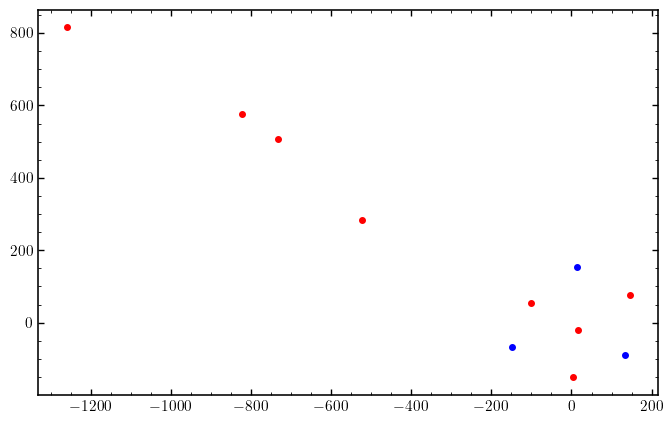

Beacon 3008 at [-1.47584719e+02 -6.62954633e+01  1.18582061e-10]
Beacon 2404 at [ 1.33207760e+02 -8.86432006e+01  1.18562937e-10]
Beacon 2407 at [1.43769586e+01 1.54938664e+02 1.18549270e-10]


In [6]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(rot_p[0], rot_p[1], color='blue', label='beacons')
ax.scatter(rot_locs[0], rot_locs[1], color='red')
plt.show()

print(f"Beacon 3008 at {rot_p[:,0]}")
print(f"Beacon 2404 at {rot_p[:,1]}")
print(f"Beacon 2407 at {rot_p[:,2]}")

<IPython.core.display.Javascript object>


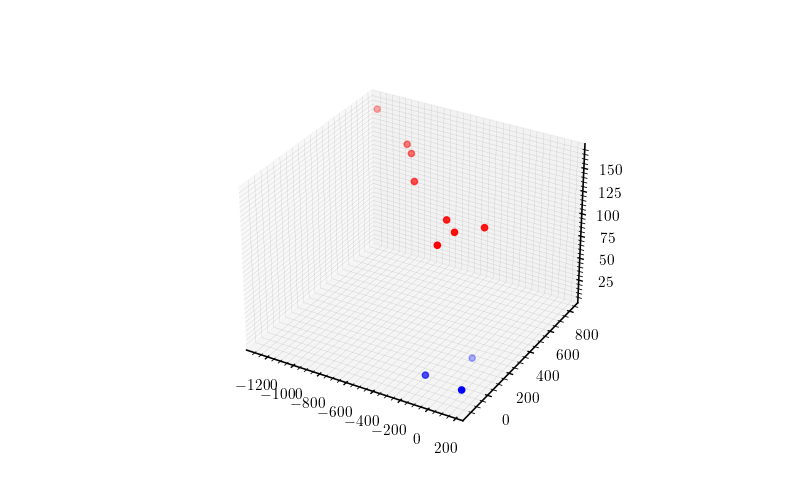

Beacon 3008 at [-1.47584719e+02 -6.62954633e+01  1.18582061e-10]
Beacon 2404 at [ 1.33207760e+02 -8.86432006e+01  1.18562937e-10]
Beacon 2407 at [1.43769586e+01 1.54938664e+02 1.18549270e-10]


In [7]:
%matplotlib notebook


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(rot_p[0], rot_p[1], rot_p[2] + 10, color='blue', label='Beacons')
ax.scatter(rot_locs[0], rot_locs[1], rot_locs[2], color='red')
#ax.scatter(rot_loc1[0], rot_loc1[1], rot_loc1[2], color='green')
#ax.scatter(rot_loc8[0], rot_loc8[1], rot_loc8[2], color='red')


#print(rot_loc8)

print(f"Beacon 3008 at {rot_p[:,0]}")
print(f"Beacon 2404 at {rot_p[:,1]}")
print(f"Beacon 2407 at {rot_p[:,2]}")

#ax.set_zlim((160, 170))
plt.show()

In [8]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mplt.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [9]:
cmap = plt.get_cmap('viridis')


def plot_recos(infile, ax, label, marker='o', add_error=False):
    hfile = hp.File(infile, 'r')
    samplers = list(hfile.keys())
    
    for i, sampler in enumerate(samplers):
        elements = list(hfile[sampler]['labels'])                                                                                                             
        elements = [x.decode('utf-8') for x in elements]                                                                                                      
        x_index = elements.index('xr[0, 0]')                                                                                                                  
        y_index = elements.index('xr[1, 0]')                                                                                                                  
        z_index = elements.index('xr[2, 0]') 
        means = hfile[sampler]['means']                                                                                                                       
        x_value = means[x_index]                                                                                                                              
        y_value = means[y_index]                                                                                                                              
        z_value = means[z_index]       
        r = np.array([x_value, y_value, z_value])
        if add_error:
            stds = hfile[sampler]['stds']                                                                                                                       
            x_error = stds[x_index]
            y_error = stds[y_index]
            z_error = stds[z_index]
            error = plt.Circle((x_value, y_value), np.max([x_error, y_error]), alpha=0.1, linestyle='', color=colors[i])
            ax.add_artist(error)
        #print(f'Sampler: {sampler}')
        #print(f'Position: {r}')
        ax.plot(x_value, y_value, label=label + sampler, marker=marker, linestyle='', alpha=0.5, color=colors[i]) #, color=colors[i]
    
    hfile.close()
    return 0


def plot_loops(infile, ax, label, marker='o'):
    hfile = hp.File(infile, 'r')
    samplers = list(hfile.keys())
    samplers = [x for x in samplers if 'NUTS' in x]
    
    for i, sampler in enumerate(samplers):
        elements = list(hfile[sampler]['labels'])                                                                                                             
        elements = [x.decode('utf-8') for x in elements]                                                                                                      
        x_index = elements.index('xr[0, 0]')                                                                                                                  
        y_index = elements.index('xr[1, 0]')                                                                                                                  
        z_index = elements.index('xr[2, 0]') 
        means = hfile[sampler]['means']                                                                                                                       
        x_value = means[x_index]                                                                                                                              
        y_value = means[y_index]                                                                                                                              
        z_value = means[z_index]                                                                                                                                                                                                                                                                
        r = np.array([x_value, y_value, z_value])
        #print(f'Sampler: {sampler}')
        #print(f'Position: {r}')
        ax.plot(x_value, y_value, label=label + sampler, marker=marker, linestyle='', color=colors[i], alpha=0.5)
    
    hfile.close()
    return 0


def plot_full_recos(infile, ax, label, marker='o', add_error=False):
    hfile = hp.File(infile, 'r')
    samplers = list(hfile.keys())
    N = len(samplers)
    numbers = np.array([int(re.findall(r'\d+', s)[0]) for s in samplers])
    sorted_indices = np.argsort(numbers)
    samplers = np.array(samplers)[sorted_indices]
    new_range = [int(i*cmap.N/N) for i in range(N)]
    colors_new = [cmap(i) for i in new_range]
    
    for i, sampler in enumerate(samplers):
        elements = list(hfile[sampler]['labels'])                                                                                                             
        elements = [x.decode('utf-8') for x in elements]                                                                                                      
        x_index = elements.index('xr[0, 0]')                                                                                                                  
        y_index = elements.index('xr[1, 0]')                                                                                                                  
        z_index = elements.index('xr[2, 0]') 
        means = hfile[sampler]['means']                                                                                                                       
        x_value = means[x_index]                                                                                                                              
        y_value = means[y_index]                                                                                                                              
        z_value = means[z_index]       
        if x_value < 800:
            continue
        r = np.array([x_value, y_value, z_value])
        #print(f'Sampler: {sampler}')
        #print(f'Position: {r}')
        if add_error:
            stds = hfile[sampler]['stds']                                                                                                                       
            x_error = stds[x_index]
            y_error = stds[y_index]
            z_error = stds[z_index]
            circle = plt.Circle((x_value, y_value), np.max([x_error, y_error]), alpha=0.05, linestyle='', color=colors_new[i])
            ax.add_artist(circle)
            #print(f'STDS are [{x_error}, {y_error}, {z_error}]')
        ax.plot(x_value, y_value, label=label + sampler, marker=marker, linestyle='', alpha=0.5, color=colors_new[i]) #, color=colors[i]

    
    hfile.close()
    return 0


def plot_multi_recos(infile, ax, label, markers=['o', '^'], add_error=False, number_of_receivers=6):
    hfile = hp.File(infile, 'r')
    samplers = list(hfile.keys())
    
    for i, sampler in enumerate(samplers):
        elements = list(hfile[sampler]['labels'])                                                                                                             
        elements = [x.decode('utf-8') for x in elements] 
        for k in range(number_of_receivers):
            x_index = elements.index(f'xr[0, {k}]')                                                                                                                  
            y_index = elements.index(f'xr[1, {k}]')                                                                                                                  
            z_index = elements.index(f'xr[2, {k}]') 
            means = hfile[sampler]['means']                                                                                                                       
            x_value = means[x_index]                                                                                                                              
            y_value = means[y_index]                                                                                                                              
            z_value = means[z_index]       
            r = np.array([x_value, y_value, z_value])
            print(r)
            if add_error:
                stds = hfile[sampler]['stds']                                                                                                                       
                x_error = stds[x_index]
                y_error = stds[y_index]
                z_error = stds[z_index]
                error = plt.Circle((x_value, y_value), np.max([x_error, y_error]), alpha=0.1, linestyle='', color=colors[i])
                ax.add_artist(error)
            ax.plot(x_value, y_value, label=label + sampler, marker=markers[k%2], linestyle='', alpha=1.0, color=colors[i]) #, color=colors[i]
    
    hfile.close()
    return 0


<IPython.core.display.Javascript object>


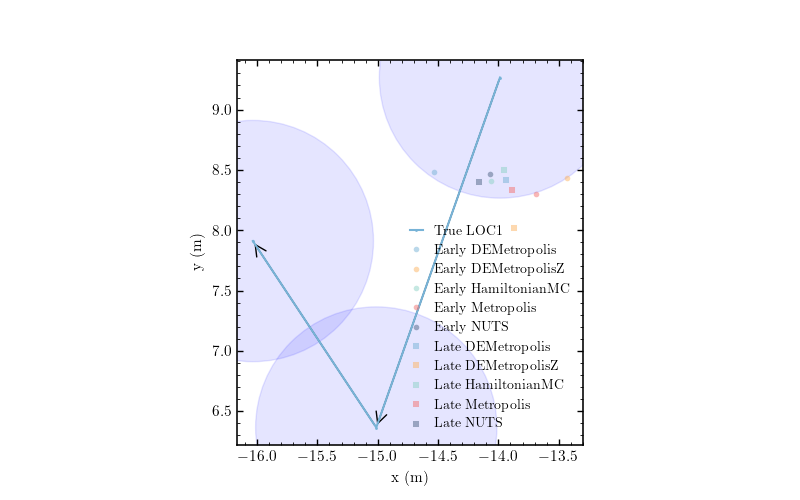

In [9]:
fig = plt.figure()
ax = fig.add_subplot()

for i in range(3):
    circle = plt.Circle((rot_loc1[0][i], rot_loc1[1][i]), 1, color='blue', alpha=0.1)
    ax.add_artist(circle)

ax.plot(rot_loc1[0], rot_loc1[1], label='True LOC1', marker='.')

#ax.plot(rot_locs[0][0], rot_locs[1][0], marker='x', linestyle='', label='old boat position')
arrow(rot_loc1[0], rot_loc1[1], ax, 2)

early_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/loc1_ch1ch2_early.hdf5'
late_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/loc1_ch1ch2_late.hdf5'
plot_recos(early_file, ax, label='Early ', marker='o')
plot_recos(late_file, ax, label='Late ', marker='s')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_aspect((1))

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


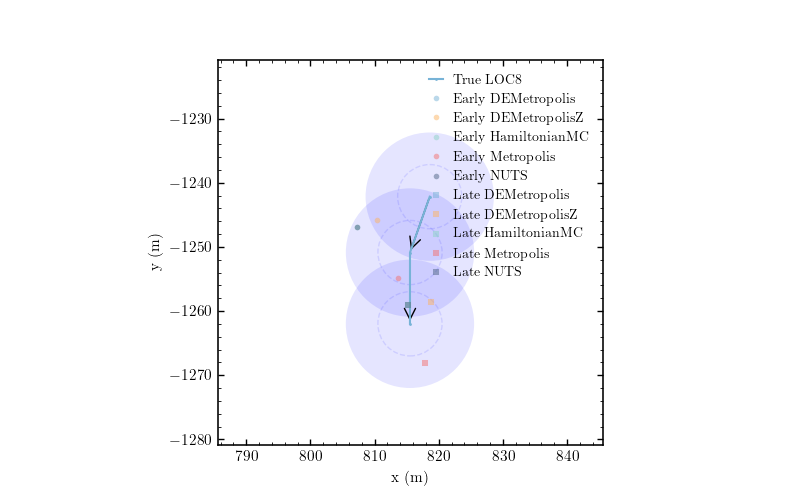

In [10]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(rot_loc8[0], rot_loc8[1], label='True LOC8', marker='.')

for i in range(3):
    circle = plt.Circle((rot_loc8[0][i], rot_loc8[1][i]), 5, color='blue', fill=False, alpha = 0.1, linestyle='--')
    circle2 = plt.Circle((rot_loc8[0][i], rot_loc8[1][i]), 10, color='blue', alpha=0.1, linestyle='')
    ax.add_artist(circle)
    ax.add_artist(circle2)
#ax.plot(rot_locs[0][0], rot_locs[1][0], marker='x', linestyle='', label='old boat position')
arrow(rot_loc8[0], rot_loc8[1], ax, 2)

early_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/loc8_ch1ch2_early.hdf5'
late_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/loc8_ch1ch2_late.hdf5'
plot_recos(early_file, ax, label='Early ', marker='o')
plot_recos(late_file, ax, label='Late ', marker='s')

ax.set_xlim((rot_loc8[0][1] - 30, rot_loc8[0][1] + 30))
ax.set_ylim((rot_loc8[1][1] - 30, rot_loc8[1][1] + 30))
ax.set_xlabel('x (m)')a
ax.set_ylabel('y (m)')
ax.set_aspect((1))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


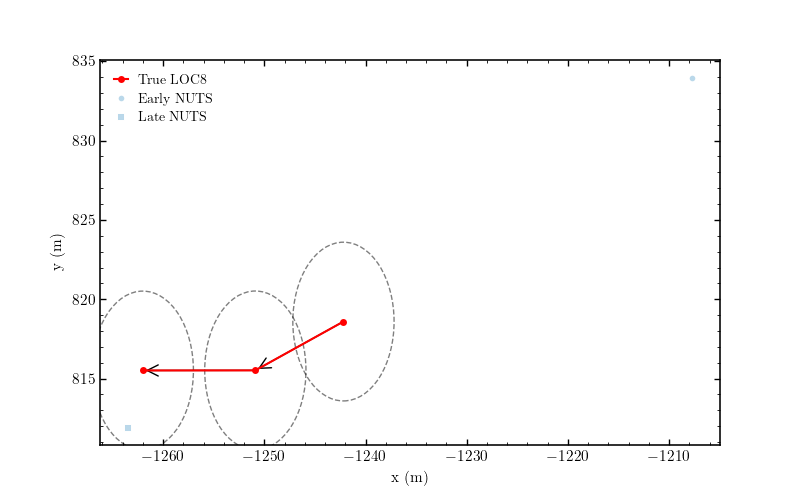

In [10]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(rot_loc8[0], rot_loc8[1], label='True LOC8', marker='.', markersize=10, color='red')
#ax.plot(rot_p[0], rot_p[1], label='Beacons', marker='^', markersize=10, color='k', linestyle='')
#ax.plot(rot_locs[0][0], rot_locs[1][0], marker='x', linestyle='', label='old boat position')
arrow(rot_loc8[0], rot_loc8[1], ax, 2)

for i in range(3):
    circle = plt.Circle((rot_loc8[0][i], rot_loc8[1][i]), 5, color='black', fill=False, alpha = 0.5, linestyle='--')
    #circle2 = plt.Circle((rot_loc8[0][i], rot_loc8[1][i]), 10, color='blue', alpha=0.1, linestyle='')
    ax.add_artist(circle)
    #ax.add_artist(circle2)

early_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC8_early.hdf5'
late_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC8_late.hdf5'
#plot_loops(early_file, ax, label='Early ', marker='o')
#plot_loops(late_file, ax, label='Late ', marker='s')
plot_recos(early_file, ax, label='Early ', marker='o')
plot_recos(late_file, ax, label='Late ', marker='s')

#ax.set_xlim((rot_loc8[0][1] - 30, rot_loc8[0][1] + 30))
#ax.set_ylim((rot_loc8[1][1] - 30, rot_loc8[1][1] + 30))
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
#ax.set_aspect((1))
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


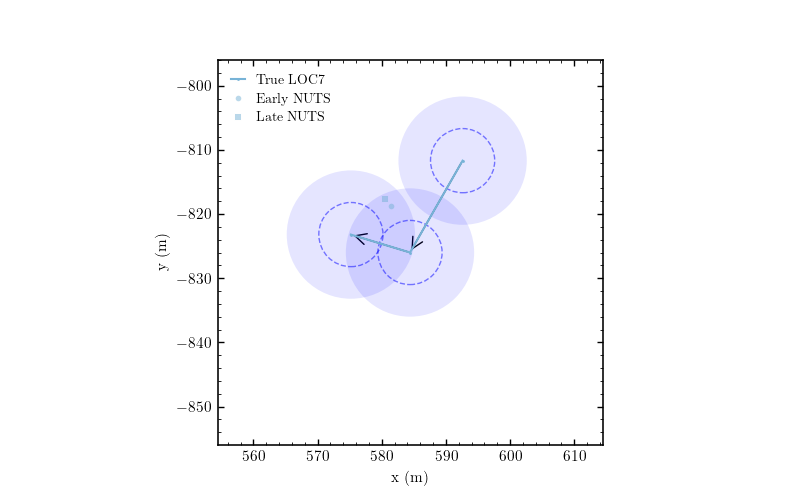

In [40]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(rot_loc7[0], rot_loc7[1], label='True LOC7', marker='.')
#ax.plot(rot_locs[0][0], rot_locs[1][0], marker='x', linestyle='', label='old boat position')
arrow(rot_loc7[0], rot_loc7[1], ax, 2)

for i in range(3):
    circle = plt.Circle((rot_loc7[0][i], rot_loc7[1][i]), 5, color='blue', fill=False, alpha = 0.5, linestyle='--')
    circle2 = plt.Circle((rot_loc7[0][i], rot_loc7[1][i]), 10, color='blue', alpha=0.1, linestyle='')
    ax.add_artist(circle)
    ax.add_artist(circle2)

early_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/loc7_early.hdf5'
late_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/loc7_late.hdf5'
plot_recos(early_file, ax, label='Early ', marker='o')
plot_recos(late_file, ax, label='Late ', marker='s')

ax.set_xlim((rot_loc7[0][1] - 30, rot_loc7[0][1] + 30))
ax.set_ylim((rot_loc7[1][1] - 30, rot_loc7[1][1] + 30))
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_aspect((1))
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


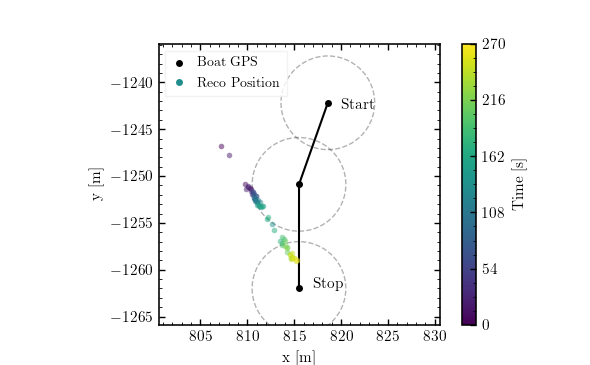

/tmp/ipykernel_35060/3615857304.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['0', '54', '108', '162', '216', '270'])


In [13]:
fig = plt.figure(figsize=(width,height))
ax = fig.add_subplot()

ax.plot(rot_loc8[0], rot_loc8[1], label='Boat GPS', marker='.', color='black', markersize=10)
#ax.plot(rot_locs[0][0], rot_locs[1][0], marker='x', linestyle='', label='old boat position')
#arrow(rot_loc8[0], rot_loc8[1], ax, 2)

for i in range(3):
    #circle = plt.Circle((rot_loc8[0][i], rot_loc8[1][i]), 5, color='blue', fill=False, alpha = 0.1, linestyle='--')
    circle2 = plt.Circle((rot_loc8[0][i], rot_loc8[1][i]), 5, color='black', fill=False, alpha=0.3, linestyle='--')
    #ax.add_artist(circle)
    ax.add_artist(circle2)


early_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/sample_data.hdf5'
plot_full_recos(early_file, ax, label='', marker='o', add_error=False)

ax.set_xlim((rot_loc8[0][1] - 15, rot_loc8[0][1] + 15))
ax.set_ylim((rot_loc8[1][1] - 15, rot_loc8[1][1] + 15))
#ax.scatter(rot_p[0], rot_p[1], color='red', marker='^')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_aspect((1))


cbar = fig.colorbar(mplt.cm.ScalarMappable(norm=mplt.colors.Normalize(0, 1), cmap='viridis'),
             ax=ax, orientation='vertical', label='Time [s]')
cbar.ax.set_yticklabels(['0', '54', '108', '162', '216', '270'])
ax.text(820, -1243, 'Start')
ax.text(817, -1262, 'Stop')
point1 = mplt.lines.Line2D([0], [0], label='Boat GPS', marker='.', markersize=10, markerfacecolor='k', linestyle='')
point2 = mplt.lines.Line2D([0], [0], label='Reco Position', marker='.', markersize=10, markerfacecolor=cmap(125), linestyle='')
plt.legend(handles=[point1, point2], loc='upper left', frameon=True)

plt.show()
plt.savefig('./reco_time.pdf', bbox_inches='tight')

In [10]:
def get_info(infile, sampler):
    hfile = hp.File(infile, 'r')
    elements = list(hfile[sampler]['labels'])                                                                                                             
    elements = [x.decode('utf-8') for x in elements]                                                                                                      
    x_index = elements.index('xr[0, 0]')                                                                                                                  
    y_index = elements.index('xr[1, 0]')                                                                                                                  
    z_index = elements.index('xr[2, 0]') 
    means = hfile[sampler]['means']                                                                                                                       
    x_value = means[x_index]                                                                                                                              
    y_value = means[y_index]                                                                                                                              
    z_value = means[z_index]       
    r = np.array([x_value, y_value, z_value])
    stds = hfile[sampler]['stds']                                                                                                                       
    x_error = stds[x_index]
    y_error = stds[y_index]
    z_error = stds[z_index]
    std = np.array([x_error, y_error, z_error])
    return r, std    

def get_beacons(infile, sampler):
    hfile = hp.File(infile, 'r')
    elements = list(hfile[sampler]['labels'])                                                                                                             
    elements = [x.decode('utf-8') for x in elements]                                                                                                      
    x_index = [elements.index(f'xb[0, {i}]') for i in range(3)]                                                                                                                  
    y_index = [elements.index(f'xb[1, {i}]') for i in range(3)]                                                                                                                  
    z_index = [elements.index(f'xb[2, {i}]') for i in range(3)] 
    means = hfile[sampler]['means']                                                                                                                       
    x_value = means[x_index]                                                                                                                              
    y_value = means[y_index]                                                                                                                              
    z_value = means[z_index]       
    r = np.array([x_value, y_value, z_value])
    stds = hfile[sampler]['stds']                                                                                                                       
    x_error = stds[x_index]
    y_error = stds[y_index]
    z_error = stds[z_index]
    std = np.array([x_error, y_error, z_error])
    return r, std  

def get_multi_info(infile, sampler, num_receivers=6):
    hfile = hp.File(infile, 'r')
    elements = list(hfile[sampler]['labels'])                                                                                                             
    elements = [x.decode('utf-8') for x in elements] 
    rs = []
    std_list = []
    for k in range(num_receivers):
        x_index = elements.index(f'xr[0, {k}]')                                                                                                                  
        y_index = elements.index(f'xr[1, {k}]')                                                                                                                  
        z_index = elements.index(f'xr[2, {k}]') 
        means = hfile[sampler]['means']                                                                                                                       
        x_value = means[x_index]                                                                                                                              
        y_value = means[y_index]                                                                                                                              
        z_value = means[z_index]       
        r = np.array([x_value, y_value, z_value])
        rs.append(r)
        stds = hfile[sampler]['stds']                                                                                                                       
        x_error = stds[x_index]
        y_error = stds[y_index]
        z_error = stds[z_index]
        std = np.array([x_error, y_error, z_error])
        std_list.append(std)
    return rs, stds


<IPython.core.display.Javascript object>


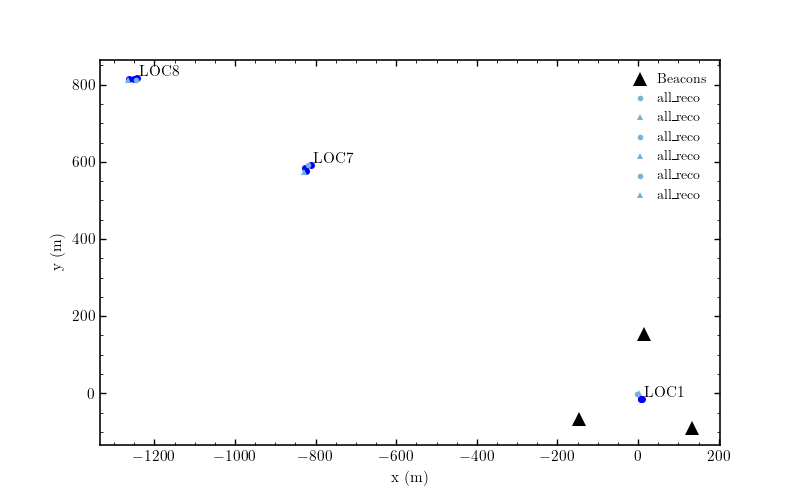

[ -3.98  -2.65 146.67]
[1.0200e+00 3.0000e-02 1.4582e+02]
[-818.99  590.84  144.89]
[-828.09  574.11  145.07]
[-1245.89   811.68   144.82]
[-1264.95   811.16   144.8 ]


In [11]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(rot_loc8[0], rot_loc8[1], marker='.', markersize=10, color='blue')
ax.text(rot_loc8[0][0] + 5, rot_loc8[1][0] + 5, 'LOC8')
ax.plot(rot_loc7[0], rot_loc7[1], marker='.', markersize=10, color='blue')
ax.text(rot_loc7[0][0] + 5, rot_loc7[1][0] + 5, 'LOC7')
ax.plot(rot_loc1[0], rot_loc1[1], marker='.', markersize=10, color='blue')
ax.text(rot_loc1[0][0] + 5, rot_loc1[1][0] + 5, 'LOC1')
ax.plot(rot_p[0], rot_p[1], label='Beacons', marker='^', markersize=10, color='k', linestyle='')

for i in range(3):
    circle = plt.Circle((rot_loc8[0][i], rot_loc8[1][i]), 5, color='black', fill=False, alpha = 0.5, linestyle='--')
    circle1 = plt.Circle((rot_loc7[0][i], rot_loc7[1][i]), 5, color='black', fill=False, alpha = 0.5, linestyle='--')
    circle2 = plt.Circle((rot_loc1[0][i], rot_loc1[1][i]), 5, color='black', fill=False, alpha = 0.5, linestyle='--')

    ax.add_artist(circle)
    ax.add_artist(circle1)
    ax.add_artist(circle2)

data_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/restricted_z_ALL_LOC.hdf5'
plot_multi_recos(data_file, ax, label='', number_of_receivers=6,add_error=True)

#ax.set_xlim((rot_loc8[0][1] - 30, rot_loc8[0][1] + 30))
#ax.set_ylim((rot_loc8[1][1] - 30, rot_loc8[1][1] + 30))
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
#ax.set_aspect((1))
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


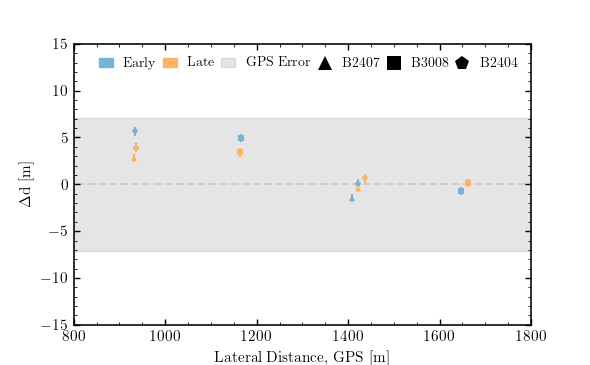

In [13]:
'''
early_file_LOC1 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC1_early.hdf5'
late_file_LOC1 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC1_late.hdf5'

early_file_LOC8 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC8_early.hdf5'
late_file_LOC8 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC8_late.hdf5'

early_file_LOC7 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC7_early.hdf5'
late_file_LOC7 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC7_late.hdf5'
'''
data_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/restricted_z_ALL_LOC.hdf5'

rs, stds = get_multi_info(data_file, sampler='all_reco', num_receivers=6)
b, bstd = get_beacons(data_file, sampler='all_reco')

labels = ['r1_early', 'r1_late', 'r7_early', 'r7_late', 'r8_early', 'r8_late']
beacon_labels = ['2407', '3008', '2404']

rot_locs = [rot_loc1,0,0,0,0,0,rot_loc7,rot_loc8]

markers = ['^', 's', 'p']
j_index = [0,1,1]

fig = plt.figure(figsize=(width,height))
ax = fig.add_subplot()

ax.fill_between([0,1800], np.sqrt(2)*5, -np.sqrt(2)*5, alpha=0.1, color='k')
error_y = 1500*(300e-6)

for i, r_i in enumerate(rs):
    d1 = np.linalg.norm(r_i[:2] - rot_p[0:2,0])
    d2 = np.linalg.norm(r_i[:2] - rot_p[0:2,1])
    d3 = np.linalg.norm(r_i[:2] - rot_p[0:2,2])
    if 'early' in labels[i]:
        j = 0
        point_label = 'Early'
    else:
        j = 2
        point_label = 'Late'
    xlabel = 'LOC' + labels[i][1]
    xvalue = int(labels[i][1])
    rot_loc = rot_locs[xvalue-1]
    d1_b = np.linalg.norm(rot_loc[0:2,j] - rot_p[0:2,0])
    d2_b = np.linalg.norm(rot_loc[0:2,j] - rot_p[0:2,1])
    d3_b = np.linalg.norm(rot_loc[0:2,j] - rot_p[0:2,2])
    d_b = [d1_b, d2_b, d3_b]
    delta_ds = [d1 - d1_b, d2 - d2_b, d3 - d3_b]
    for k, delta_d in enumerate(delta_ds):
        ax.errorbar(d_b[k], delta_d, color=colors[j_index[j]], marker=markers[k], yerr=error_y)

#ax.set_xticks(ticks = x_values, labels = [f'LOC{i}' for i in x_values])

early_color = mplt.patches.Patch(color=colors[0], label='Early')
late_color = mplt.patches.Patch(color=colors[1], label='Late')
error_color = mplt.patches.Patch(color='k',alpha=0.1, label='GPS Error')


point1 = mplt.lines.Line2D([0], [0], label='B2407', marker=markers[0], markersize=10, markerfacecolor='k', linestyle='')
point2 = mplt.lines.Line2D([0], [0], label='B3008', marker=markers[1], markersize=10, markerfacecolor='k', linestyle='')
point3 = mplt.lines.Line2D([0], [0], label='B2404', marker=markers[2], markersize=10, markerfacecolor='k', linestyle='')

handles = [early_color, late_color, error_color, point1, point2, point3]

ax.set_ylabel(r'$\Delta$d [m]')
ax.set_xlabel('Lateral Distance, GPS [m]')
ax.plot([0,1800], [0,0], linestyle='--', color='k', alpha=0.1)
ax.set_xlim([800, 1800])
#ax.set_xlim([100, 1700])
ax.set_ylim([-15, 15])
#ax.set_xscale('log')
plt.legend(handles=handles, ncol=6)
plt.show()
plt.savefig('./reco_lateral.pdf', bbox_inches='tight')

In [45]:
print(r1_early)
print(r1_late)
print(r7_early)
print(r7_late)
print(r8_early)
print(r8_late)

[-13.83   7.8  152.77]
[-13.21   7.51 144.38]
[ 581.99 -819.58  149.61]
[ 581.17 -818.61  149.47]
[  807.59 -1247.42   145.41]
[  815.48 -1259.73   146.77]


<IPython.core.display.Javascript object>


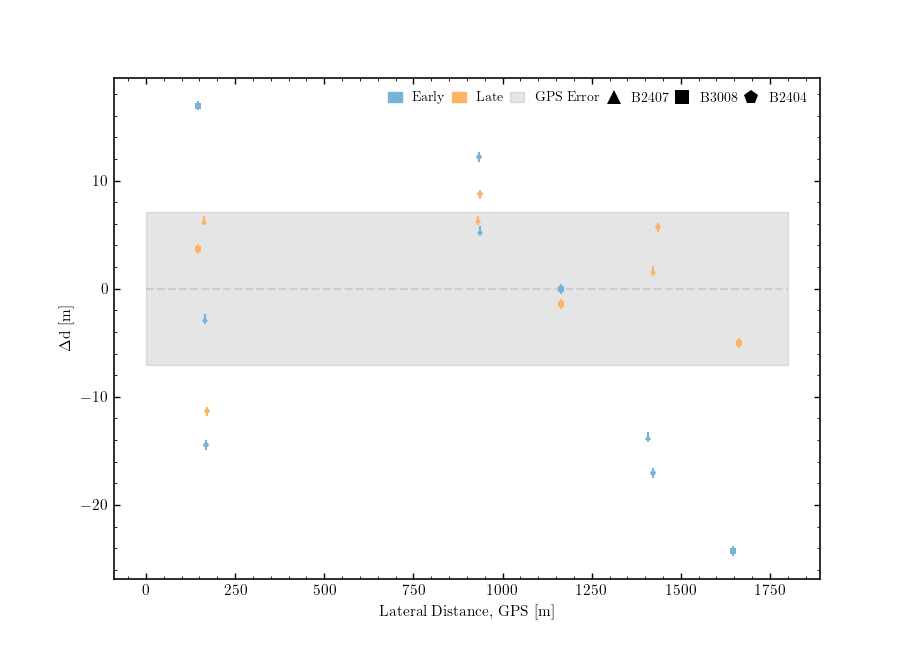

In [39]:

fig = plt.figure(figsize=(width,height))
ax = fig.add_subplot()

ax.fill_between([0,1800], np.sqrt(2)*5, -np.sqrt(2)*5, alpha=0.1, color='k')
error_y = 1500*(300e-6)

for i, r_i in enumerate(r):
    beacons = b
    d1 = np.linalg.norm(r_i[:2] - beacons[0:2,0])
    d2 = np.linalg.norm(r_i[:2] - beacons[0:2,1])
    d3 = np.linalg.norm(r_i[:2] - beacons[0:2,2])
    if 'early' in labels[i]:
        j = 0
        point_label = 'Early'
    else:
        j = 2
        point_label = 'Late'
    xlabel = 'LOC' + labels[i][1]
    xvalue = int(labels[i][1])
    rot_loc = rot_locs[xvalue-1]
    d1_b = np.linalg.norm(rot_loc[0:2,j] - rot_p[0:2,0])
    d2_b = np.linalg.norm(rot_loc[0:2,j] - rot_p[0:2,1])
    d3_b = np.linalg.norm(rot_loc[0:2,j] - rot_p[0:2,2])
    d_b = [d1_b, d2_b, d3_b]
    delta_ds = [d1 - d1_b, d2 - d2_b, d3 - d3_b]
    for k, delta_d in enumerate(delta_ds):
        ax.errorbar(d_b[k], delta_d, color=colors[j_index[j]], marker=markers[k], yerr=error_y)
        
ax.set_ylabel(r'$\Delta$d [m]')
ax.set_xlabel('Lateral Distance, GPS [m]')
ax.plot([0,1800], [0,0], linestyle='--', color='k', alpha=0.1)
#ax.set_xlim([0.5, 1700])
#ax.set_xlim([100, 1700])
#ax.set_ylim([-15, 15])
#ax.set_xscale('log')
plt.legend(handles=handles, ncol=6)
plt.show()

<IPython.core.display.Javascript object>


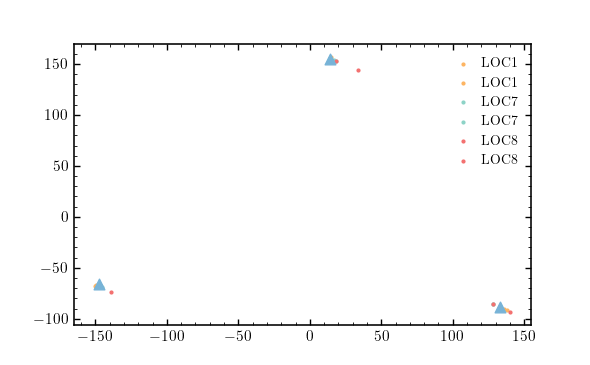

1
1
7
7
8
8


In [15]:
early_file_LOC1 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC1_early.hdf5'
late_file_LOC1 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC1_late.hdf5'

early_file_LOC8 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC8_early.hdf5'
late_file_LOC8 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC8_late.hdf5'

early_file_LOC7 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC7_early.hdf5'
late_file_LOC7 = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/LOC7_late.hdf5'


b1_early, std_b1_early = get_beacons(early_file_LOC1, 'NUTS')
b1_late, std_b1_late = get_beacons(late_file_LOC1, 'NUTS')
b8_early, std_b8_early = get_beacons(early_file_LOC8, 'NUTS')
b8_late, std_b8_late = get_beacons(late_file_LOC8, 'NUTS')
b7_early, std_b7_early = get_beacons(early_file_LOC7, 'NUTS')
b7_late, std_b7_late = get_beacons(late_file_LOC7, 'NUTS')

b = [b1_early, b1_late, b7_early, b7_late, b8_early, b8_late]

convert_index = np.array([1,1,1,1,1,1,1,2,3])

fig = plt.figure(figsize=(width,height))
ax = fig.add_subplot()

for i, beacon in enumerate(b):
    xlabel = 'LOC' + labels[i][1]
    xvalue = int(labels[i][1])
    print(xvalue)
    ax.scatter(beacon[0], beacon[1], marker='.', label=xlabel, color=colors[convert_index[xvalue]])
    
ax.scatter(rot_p[0], rot_p[1], marker='^', s=59)
plt.legend()

<IPython.core.display.Javascript object>


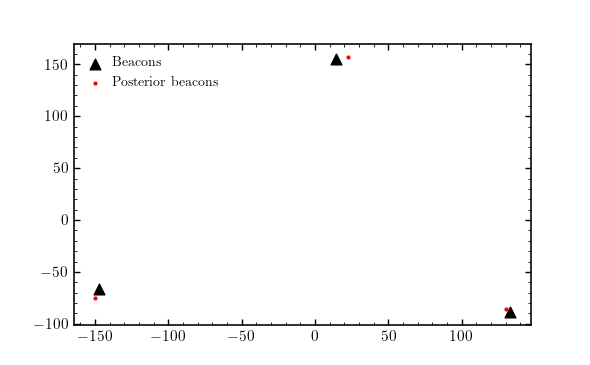

In [87]:
test_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/restricted_z_ALL_LOC.hdf5'
beacon, std_b = get_beacons(test_file, 'all_reco')

fig = plt.figure(figsize=(width,height))
ax = fig.add_subplot()


ax.scatter(rot_p[0], rot_p[1], marker='^', s=59, label='Beacons', color='k')
ax.scatter(beacon[0], beacon[1], marker='.', label='Posterior beacons', color='r')
plt.legend(loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


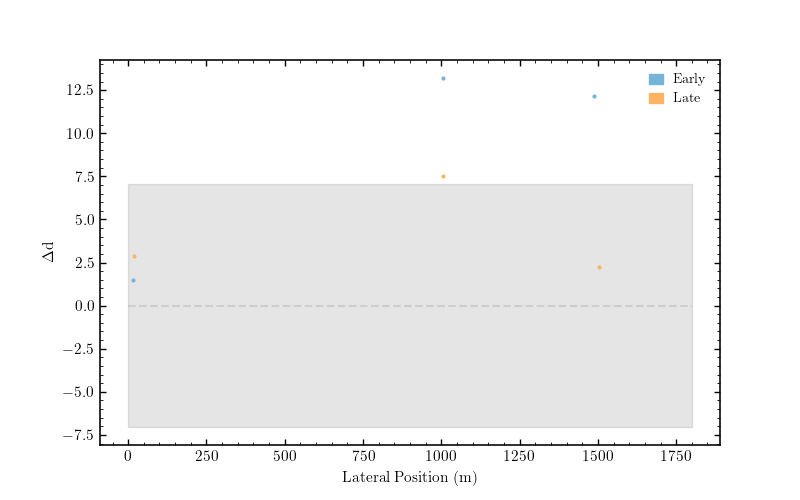

In [20]:
fig = plt.figure()
ax = fig.add_subplot()

ax.fill_between([0,1800], np.sqrt(2)*5, -np.sqrt(2)*5, alpha=0.1, color='k')
error_y = 1500*(300e-6)

for i, r_i in enumerate(r):
    if 'early' in labels[i]:
        j = 0
        point_label = 'Early'
    else:
        j = 2
        point_label = 'Late'
    xlabel = 'LOC' + labels[i][1]
    xvalue = int(labels[i][1])
    rot_loc = rot_locs[xvalue-1]
    d = np.linalg.norm(r_i[:2] - rot_loc[0:2, j])
    x = np.linalg.norm(rot_loc[0:2,j])
    ax.scatter(x, d, color=colors[j_index[j]], marker='.')

#ax.set_xticks(ticks = x_values, labels = [f'LOC{i}' for i in x_values])

early_color = mplt.patches.Patch(color=colors[0], label='Early')
late_color = mplt.patches.Patch(color=colors[1], label='Late')

#point1 = mplt.lines.Line2D([0], [0], label='B2407', marker=markers[0], markersize=10, markerfacecolor='k', linestyle='')
#point2 = mplt.lines.Line2D([0], [0], label='B3008', marker=markers[1], markersize=10, markerfacecolor='k', linestyle='')
#point3 = mplt.lines.Line2D([0], [0], label='B2404', marker=markers[2], markersize=10, markerfacecolor='k', linestyle='')

handles = [early_color, late_color]#, point1, point2, point3]

ax.set_ylabel(r'$\Delta$d [m]')
ax.set_xlabel('Lateral Position [m]')
ax.plot([0,1800], [0,0], linestyle='--', color='k', alpha=0.1)
#ax.set_xlim([0.5, 1700])
#ax.set_ylim([-10, 10])
plt.legend(handles=handles)
plt.show()